In [95]:
using LinearAlgebra

using Plots
default(fmt = :png)

using DifferentialEquations
using Flux
using DiffEqFlux

using CuArrays

In [96]:
const N = 64
const L = 2
const Δx = L / N
const κ = 1

x = range(-L/2, L/2, length=N)

datasize = 30
tspan = (0.0, 0.1)
t = range(tspan[1], tspan[2], length=datasize)

0.0:0.0034482758620689655:0.1

In [97]:
 d = -2 * ones(N)
sd = ones(N-1)
A = Array(Tridiagonal(sd, d, sd))
A[1, N] = 1
A[N, 1] = 1
A_diffusion = (κ/Δx^2) .* A |> gpu

function diffusion!(u, p, t)
    return A_diffusion * u
end

diffusion! (generic function with 2 methods)

In [98]:
u₀s = [
    x -> exp(-50x^2),
    x -> cos(π*x),
    x -> sin(π*x)
]

3-element Array{Function,1}:
 getfield(Main, Symbol("##47#50"))()
 getfield(Main, Symbol("##48#51"))()
 getfield(Main, Symbol("##49#52"))()

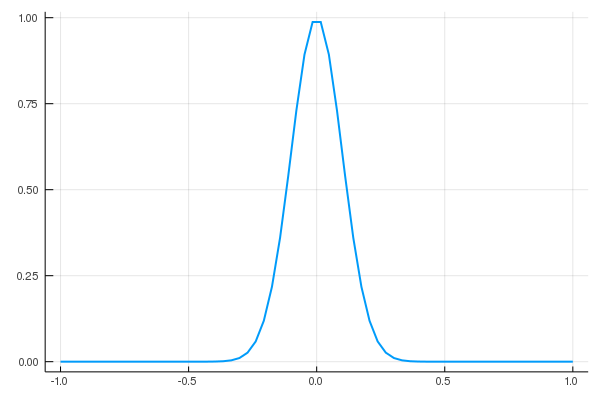

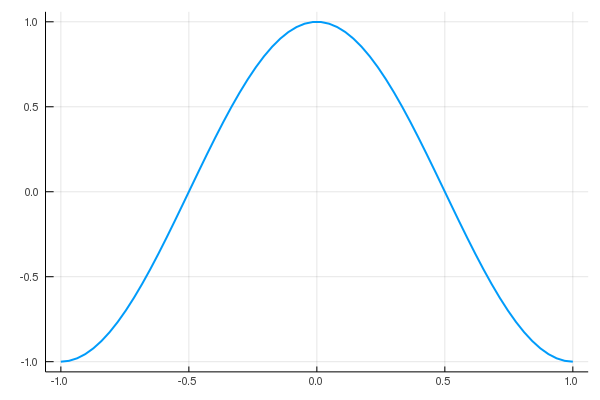

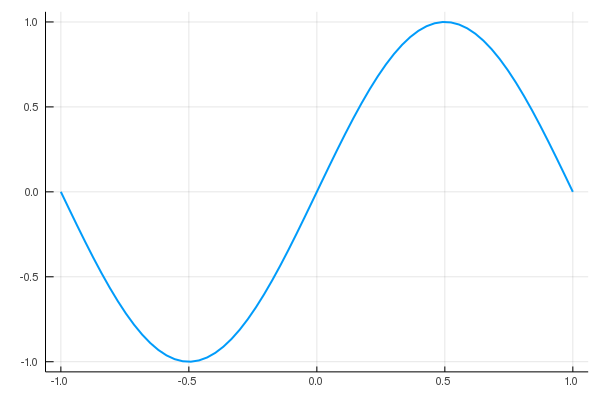

In [99]:
for u₀ in u₀s
    display(plot(x, u₀.(x), linewidth=2, label=""))
end

In [100]:
pde_data = []
for (i, u₀) in enumerate(u₀s)
    println("Generating PDE data with initial condition $i...")
    
    u₀_ic = (@. u₀(x)) |> gpu
    prob = ODEProblem(diffusion!, u₀_ic, tspan)
    solution = solve(prob, Tsit5(), saveat=t) |> gpu
    
    push!(pde_data, solution)
end

Generating PDE data with initial condition 1...
Generating PDE data with initial condition 2...
Generating PDE data with initial condition 3...


In [101]:
dudt_NN = Chain(Dense(N, N, tanh),
                Dense(N, N)) |> gpu

ps = Flux.params(dudt_NN)

neural_pde_prediction = u₀ -> neural_ode(dudt_NN, u₀, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)

#53 (generic function with 1 method)

In [102]:
M = length(u₀s)
u₀_data = zeros(M, N) |> gpu

for (i, u₀) in enumerate(u₀s)
    u₀_data[i, :] = u₀s[i].(x) |> gpu
end

loss_function() = sum(sum(abs2, pde_data[i] .- neural_pde_prediction(u₀_data[i, :])) for i in 1:M)

loss_function (generic function with 1 method)

In [103]:
data = Iterators.repeated((), 1000)
opt = ADAM(0.1)

ADAM(0.1, (0.9, 0.999), IdDict{Any,Any}())

In [104]:
# Callback function to observe training.
cb = function ()
    loss = loss_function()
    println("loss = $loss")
    loss < 1 && Flux.stop()
end

#57 (generic function with 1 method)

In [105]:
Flux.train!(loss_function, ps, data, opt, cb = cb)

loss = 257.86786f0 (tracked)
loss = 66.41269f0 (tracked)
loss = 85.34701f0 (tracked)
loss = 104.84854f0 (tracked)
loss = 91.91027f0 (tracked)
loss = 57.893414f0 (tracked)
loss = 25.992954f0 (tracked)
loss = 19.974264f0 (tracked)
loss = 33.949318f0 (tracked)
loss = 43.299065f0 (tracked)
loss = 36.92677f0 (tracked)
loss = 23.93417f0 (tracked)
loss = 16.508518f0 (tracked)
loss = 17.226234f0 (tracked)
loss = 20.65515f0 (tracked)
loss = 21.441378f0 (tracked)
loss = 18.956385f0 (tracked)
loss = 15.504366f0 (tracked)
loss = 12.6352215f0 (tracked)
loss = 11.013615f0 (tracked)
loss = 11.072952f0 (tracked)
loss = 11.172718f0 (tracked)
loss = 10.710785f0 (tracked)
loss = 9.699742f0 (tracked)
loss = 8.404725f0 (tracked)
loss = 7.328263f0 (tracked)
loss = 6.748145f0 (tracked)
loss = 6.74059f0 (tracked)
loss = 6.9578295f0 (tracked)
loss = 6.977872f0 (tracked)
loss = 6.554632f0 (tracked)
loss = 5.8562245f0 (tracked)
loss = 5.1868362f0 (tracked)
loss = 4.9083033f0 (tracked)
loss = 4.983741f0 (tracked)

In [38]:
for (i, (u₀, pde_data_i)) in enumerate(zip(u₀s, pde_data))
    u₀_ic = (@. u₀(x)) |> gpu
    nn_pred = Flux.data(neural_pde_prediction(u₀_ic))
    
    println("Creating .gif for data from initial condition $i...")
    anim = @gif for n=1:datasize
        plot(x, pde_data_i[:, n], linewidth=2, ylim=(-1, 1), label="data", show=false)
        plot!(x, nn_pred[:, n],   linewidth=2, ylim=(-1, 1), label="Neural ODE", show=false)
    end
    
    display(anim)
end

Creating .gif for data from initial condition 1...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

Creating .gif for data from initial condition 2...


┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 3...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


In [93]:
u₀s_test = [
    x -> 0.5,
    x -> exp(-50*abs(x)),
    x -> cos(2π*x),
    x -> sin(2π*x)
]

4-element Array{Function,1}:
 getfield(Main, Symbol("##39#43"))()
 getfield(Main, Symbol("##40#44"))()
 getfield(Main, Symbol("##41#45"))()
 getfield(Main, Symbol("##42#46"))()

In [94]:
for (i, u₀) in enumerate(u₀s_test)
    u₀_ic = (@. u₀(x)) |> gpu
    
        prob = ODEProblem(diffusion!, u₀_ic, tspan)
    solution = solve(prob, Tsit5(), saveat=t) |> gpu
    
    nn_pred = Flux.data(neural_pde_prediction(u₀_ic))
    
    println("Creating .gif for data from initial condition $i...")
    anim = @gif for n=1:datasize
        plot(x, solution[:, n], linewidth=2, ylim=(-1, 1), label="data", show=false)
        plot!(x, nn_pred[:, n], linewidth=2, ylim=(-1, 1), label="Neural ODE", show=false)
    end
    
    display(anim)
end

Creating .gif for data from initial condition 1...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 2...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 3...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 4...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95
